In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils.config import Config

In [3]:
pred = xr.open_dataset("output/pred_E.nc")
pred

<xarray.Dataset> Size: 4GB
Dimensions:  (lat: 720, lon: 1440, time: 480)
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 4kB 1984-01-01 1984-02-01 ... 2023-12-01
Data variables:
    fwet     (lat, lon, time) float64 4GB ...

In [4]:
config = Config("config/E.toml", "predict")
TVARs = config.TVARs
TVARs.keys()

dict_keys(['giems2', 'era5', 'mswep', 'gleam', 'grace'])

In [5]:
mask = config.mask
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(720, 1440))

In [7]:
pixel_area = xr.open_dataset("data/clean/PixelArea_area.nc")
pixel_area

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    area     (lat, lon) float64 8MB ...

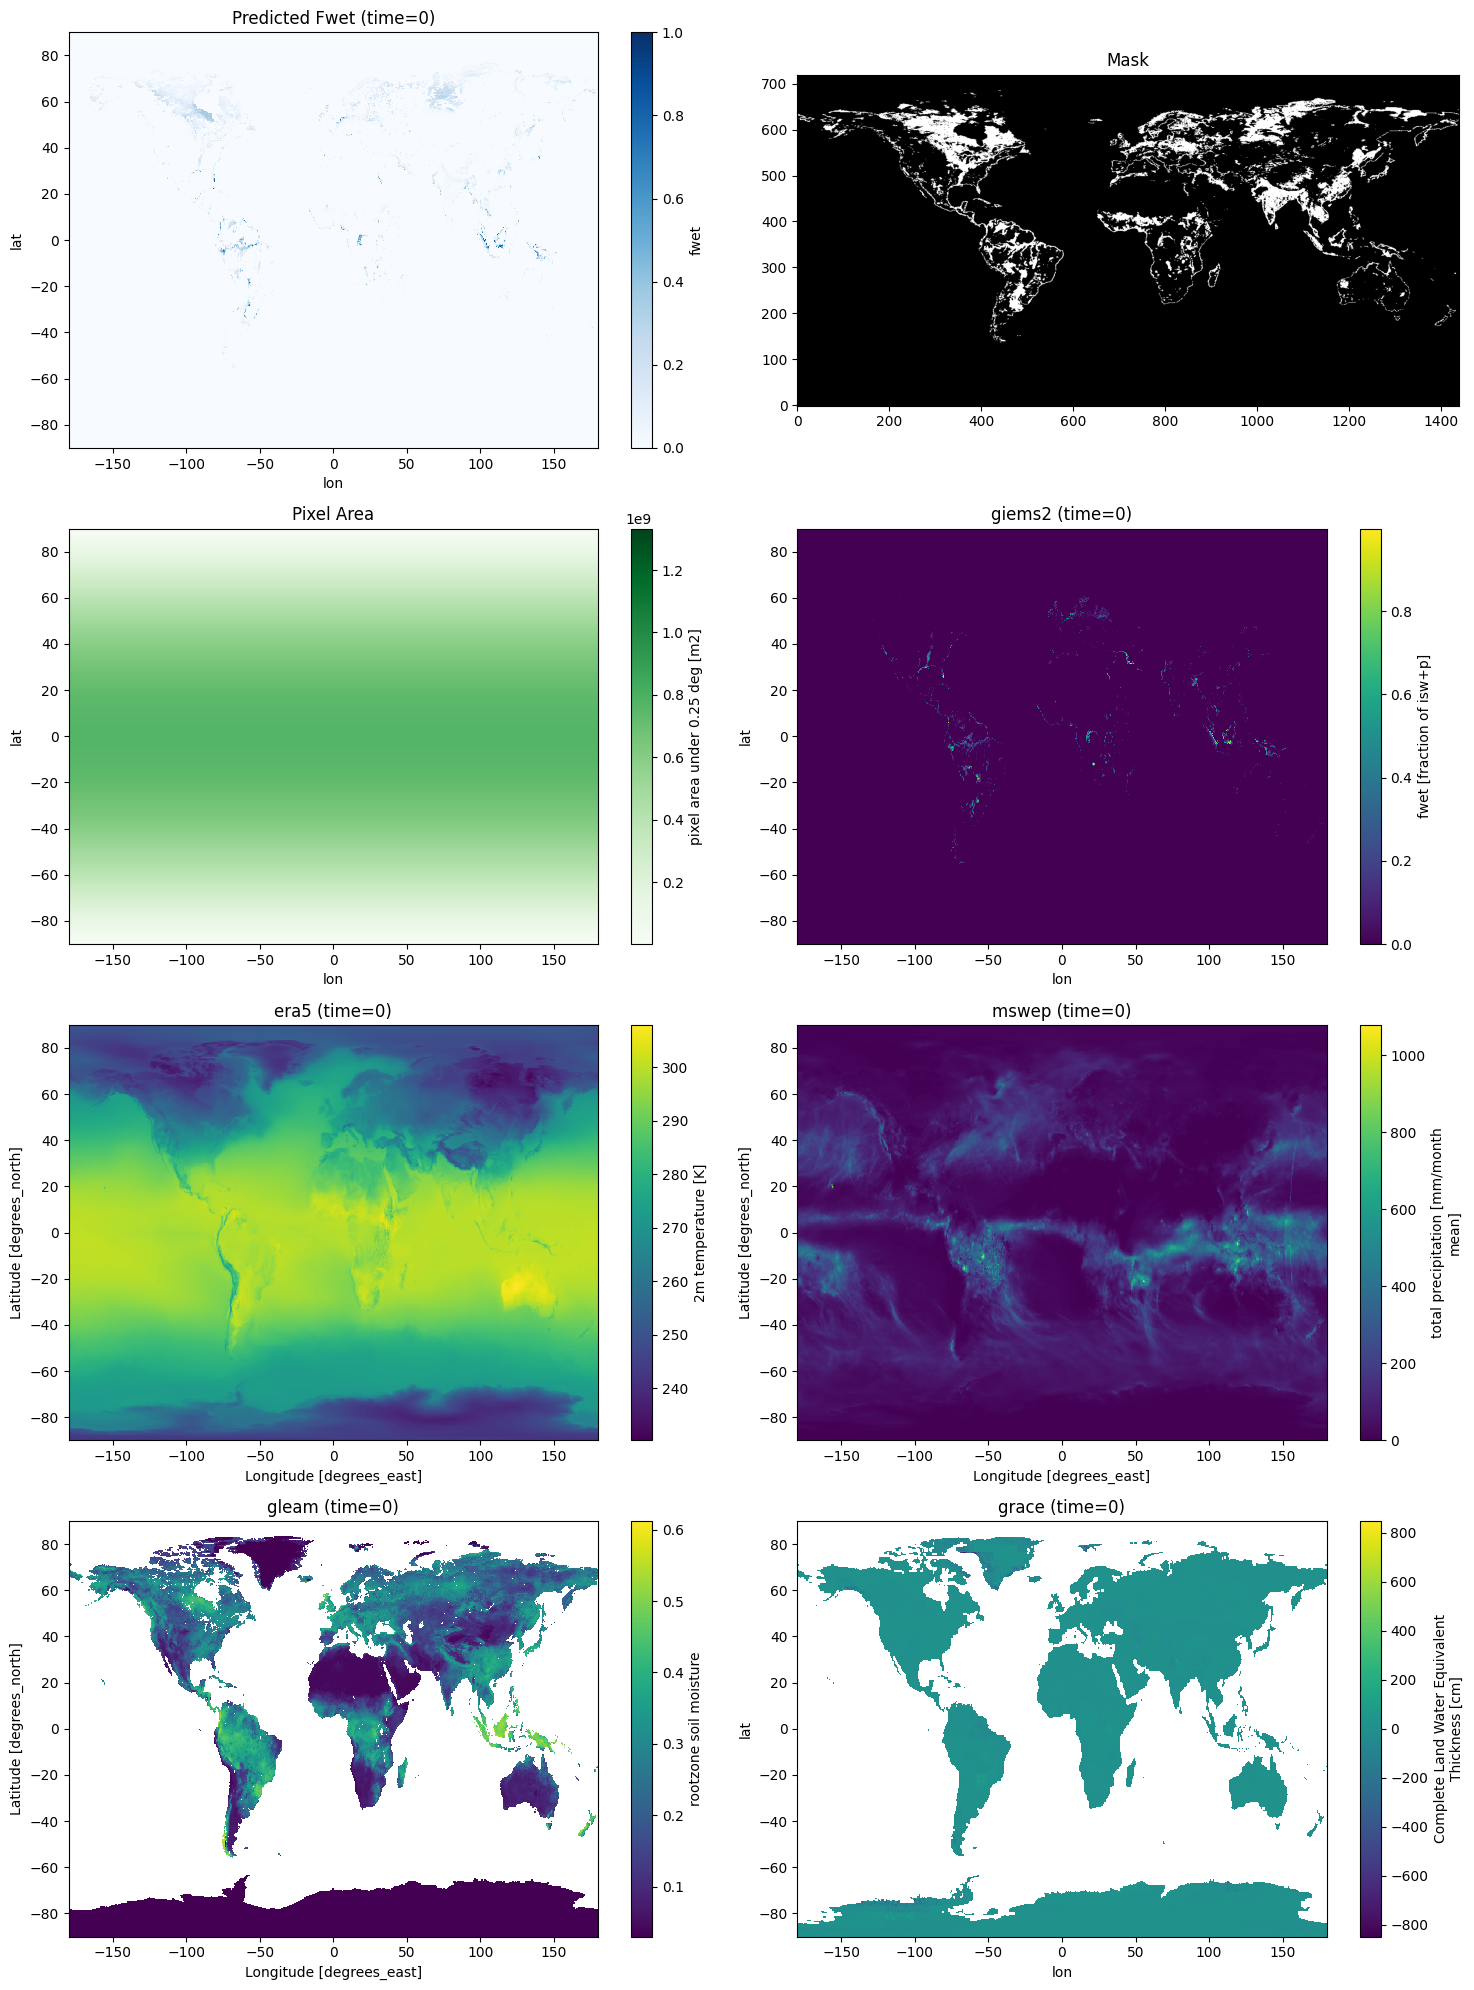

In [15]:
# Overall view
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

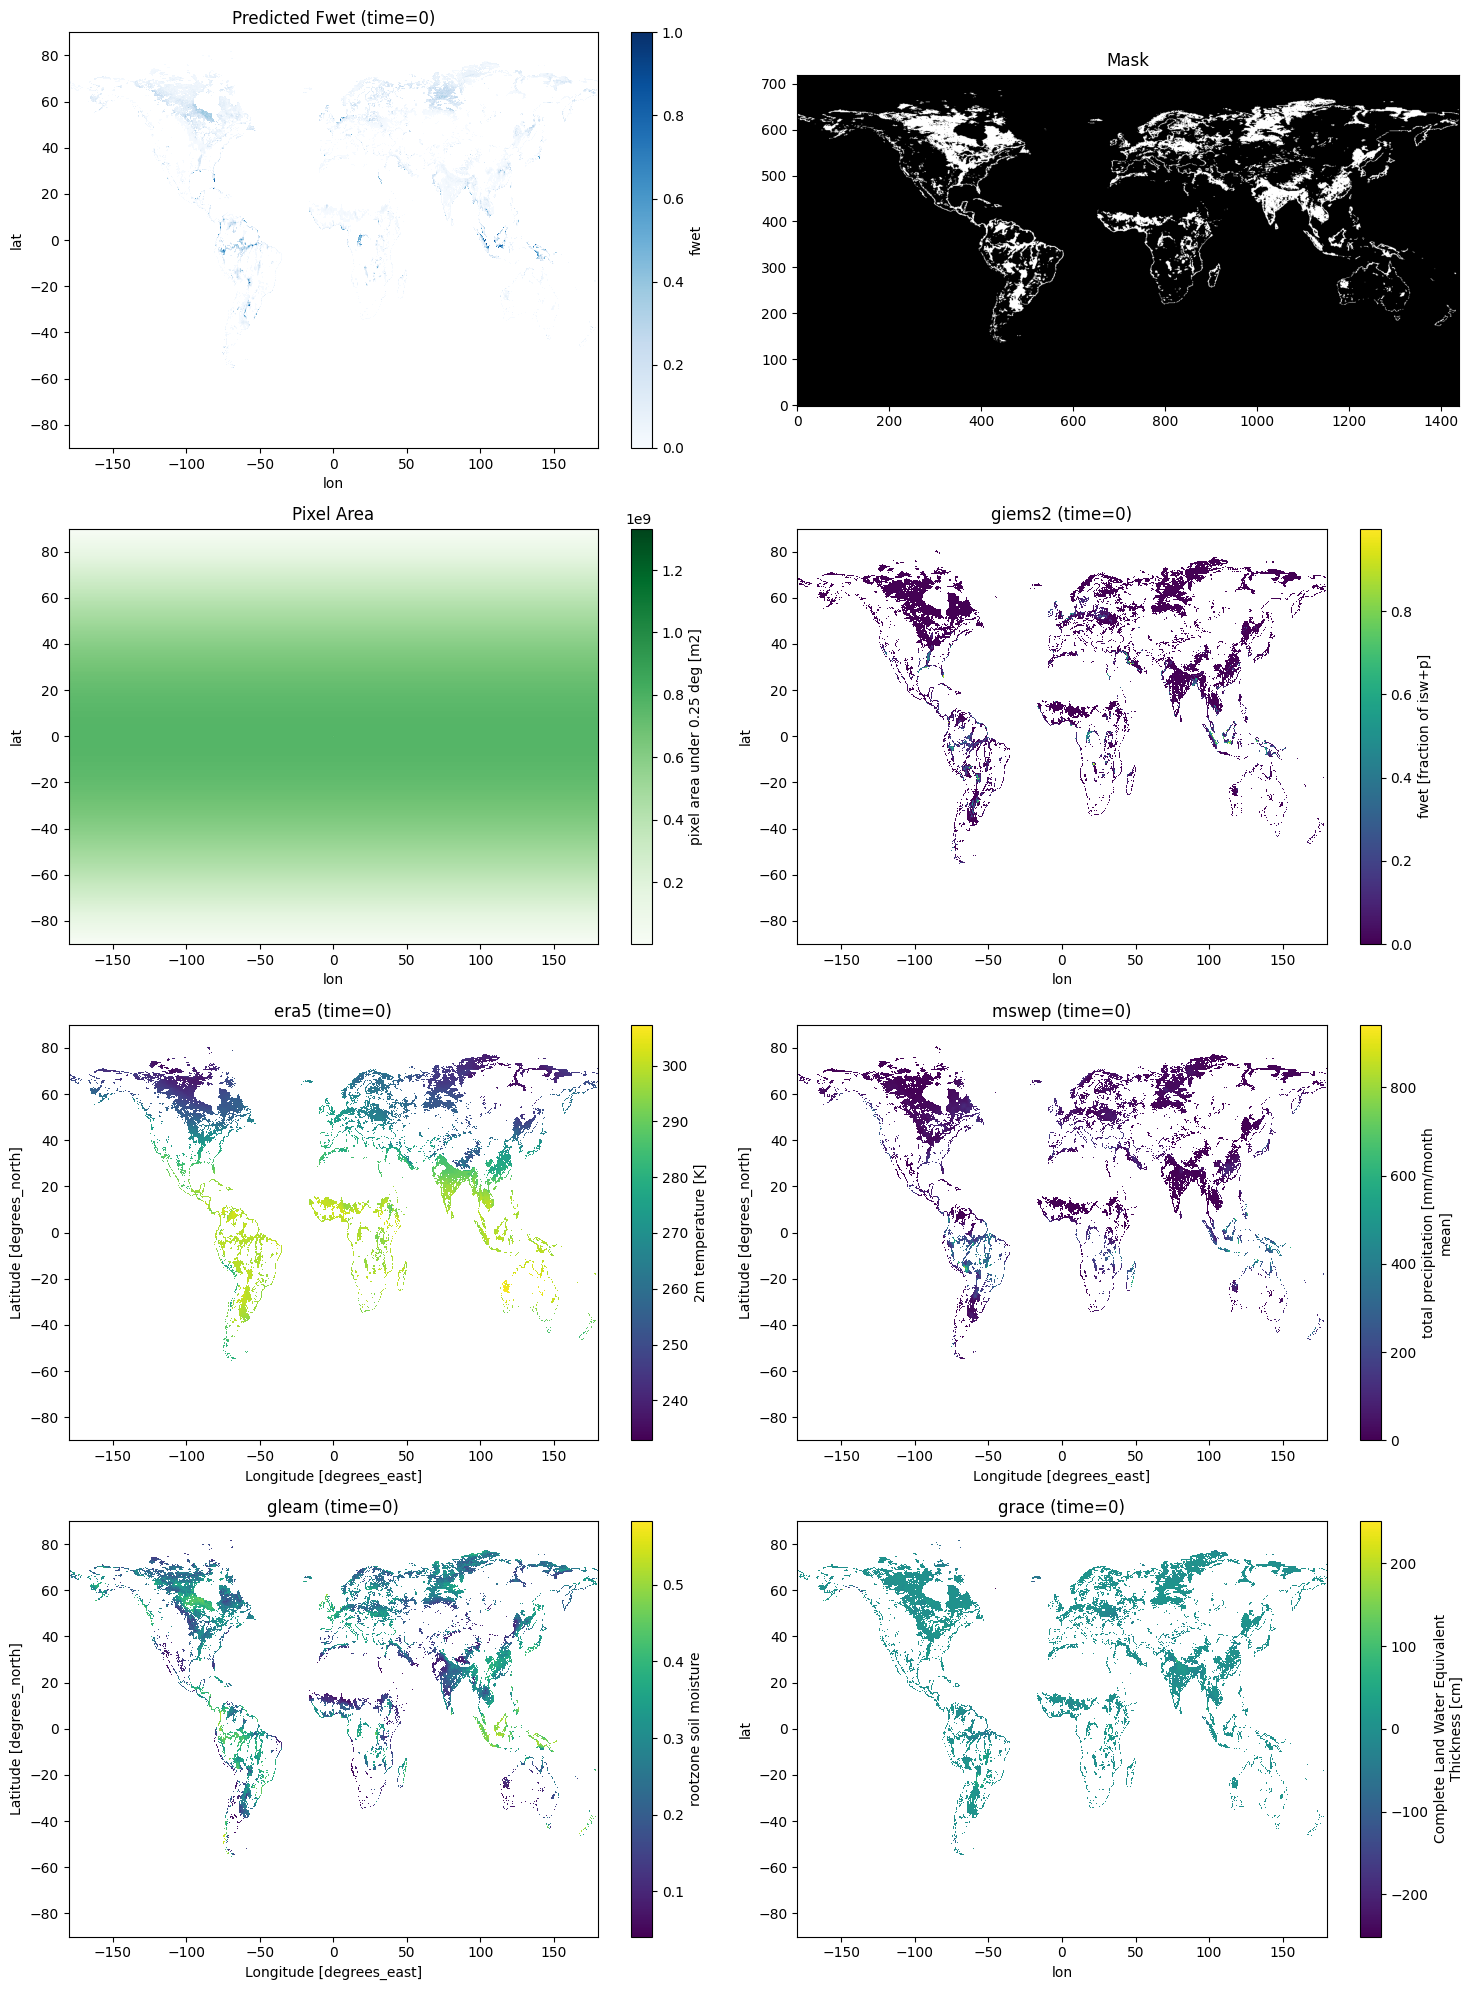

In [18]:
# all the data need to be masked
for var in TVARs.keys():
    TVARs[var] = TVARs[var].where(mask)

pred = pred.transpose("time", "lat", "lon")
pred["fwet"] = pred["fwet"].where(mask)

# check again
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

In [20]:
# apply weights
pred_area = pred["fwet"] * pixel_area["area"]
giems_area = TVARs["giems2"] * pixel_area["area"]

weight = np.nanmax(TVARs["giems2"].values, axis=0)
grace_weighted = TVARs["grace"] * weight
mswep_weighted = TVARs["mswep"] * weight
gleam_weighted = TVARs["gleam"] * weight

C:\Users\FireFighter\AppData\Local\Temp\ipykernel_2032\70453930.py:5: RuntimeWarning: All-NaN slice encountered
  weight = np.nanmax(TVARs["giems2"].values, axis=0)


## Global

In [26]:
def compute_GY(dataarray: xr.DataArray):
    return dataarray.mean(dim=["lat", "lon"], skipna=True).resample(time="YS").mean()


pred_area_GY = compute_GY(pred_area)
giems_area_GY = compute_GY(giems_area)
grace_weighted_GY = compute_GY(grace_weighted)
mswep_weighted_GY = compute_GY(mswep_weighted)
gleam_weighted_GY = compute_GY(gleam_weighted)

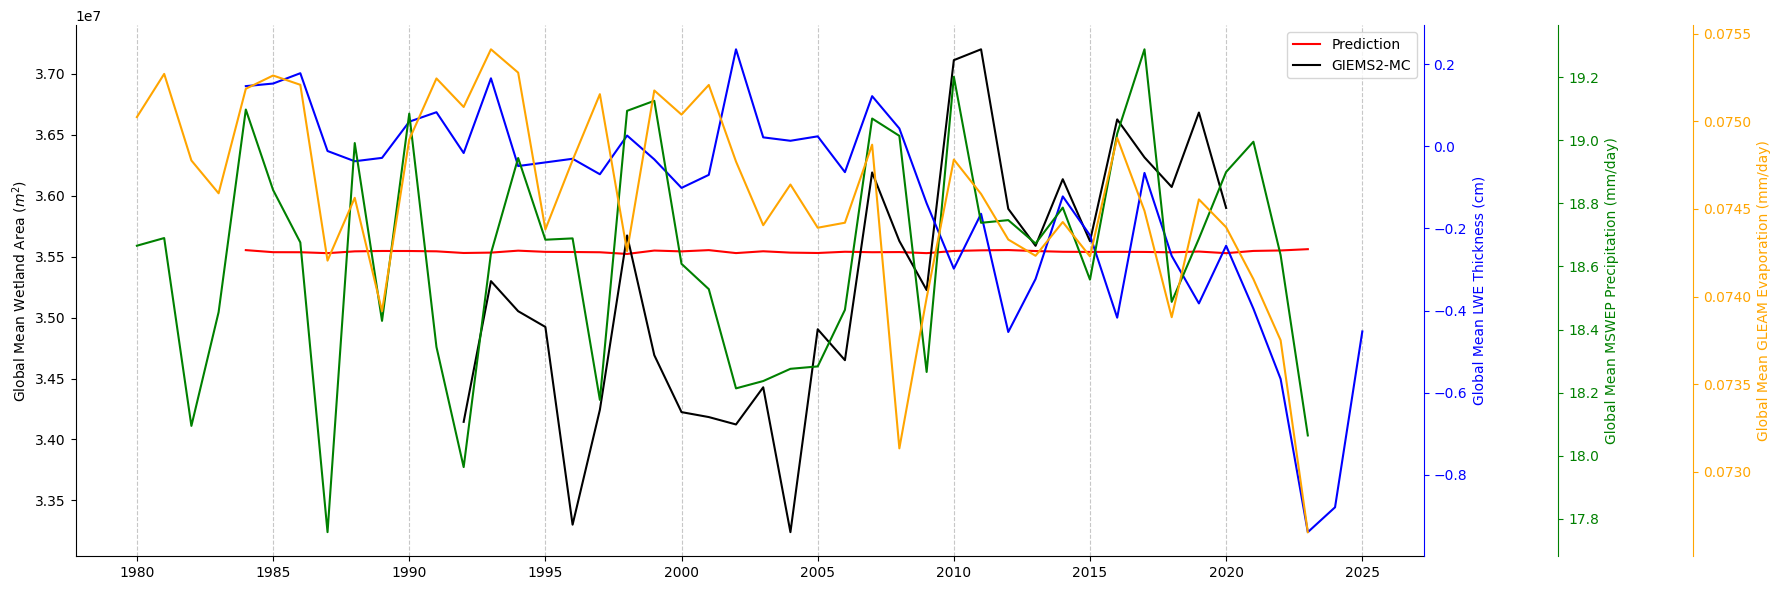

In [45]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    pred_area_GY.time,
    pred_area_GY,
    label="Prediction",
    color="red",
)
ax.plot(
    giems_area_GY.time,
    giems_area_GY,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel("Global Mean Wetland Area ($m^2$)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


def draw_compare(dataarray, offset, label, color):
    bx = ax.twinx()
    bx.plot(
        dataarray.time,
        dataarray,
        color=color,
    )
    bx.spines["right"].set_position(("axes", offset))
    bx.spines["right"].set_color(color)
    bx.spines["left"].set_visible(False)
    bx.spines["top"].set_visible(False)
    bx.spines["bottom"].set_visible(False)
    bx.grid(False)
    bx.set_ylabel(label, color=color)
    bx.yaxis.label.set_color(color)
    bx.tick_params(axis="y", colors=color)


draw_compare(grace_weighted_GY, 1, "Global Mean LWE Thickness (cm)", "blue")
draw_compare(
    mswep_weighted_GY, 1.1, "Global Mean MSWEP Precipitation (mm/day)", "green"
)
draw_compare(gleam_weighted_GY, 1.2, "Global Mean GLEAM Evaporation (mm/day)", "orange")
fig.tight_layout()